## Part 1

In [ ]:
# Installing necessary libraries
!pip install pyspark
!pip install mlxtend

# Importing necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace, col, round
import pandas as pd
import matplotlib.pyplot as plt
import requests
import gzip
import shutil
import os
from scipy.spatial.distance import pdist, squareform
from mlxtend.frequent_patterns import apriori, association_rules

# Defining file paths
url = "https://github.com/tulip-lab/sit742/blob/develop/Assessment/2024/data/transactionrecord.gz?raw=true"
gz_file_path = "/content/transactionrecord.gz"
csv_file_path = "/content/transactionrecord.csv"

# Downloading the .gz file
response = requests.get(url, stream=True)
with open(gz_file_path, "wb") as f:
    f.write(response.content)

# Extracting the .gz file to get the .csv
with gzip.open(gz_file_path, 'rb') as f_in:
    with open(csv_file_path, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

# Deleting the downloaded .gz file to clean up storage
if os.path.exists(gz_file_path):
    os.remove(gz_file_path)

# Clear the output (for cleaner notebook display)
from IPython.display import clear_output
clear_output(wait=True)

# Starting a Spark session
spark = SparkSession.builder.appName("DataWrangling").getOrCreate()

# Loading the extracted CSV data into a Spark DataFrame
df = spark.read.csv(csv_file_path, header=True, inferSchema=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Printing the schema and columns to see the column names and types
df.printSchema()
print(df.columns)

root
 |-- TransactionNo: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- ProductNo: string (nullable = true)
 |-- ProductName: string (nullable = true)
 |-- Product_category: string (nullable = true)
 |-- Price: double (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- CustomerNo: integer (nullable = true)
 |-- Country: string (nullable = true)

['TransactionNo', 'Date', 'ProductNo', 'ProductName', 'Product_category', 'Price', 'Quantity', 'CustomerNo', 'Country']


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Showing the first 5 rows
df.select('TransactionNo', 'Date', 'ProductNo', 'ProductName', 'Product_category', 'Price', 'Quantity', 'CustomerNo', 'Country').show(5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


+-------------+---------+---------+--------------------+----------------+-----+--------+----------+--------------+
|TransactionNo|     Date|ProductNo|         ProductName|Product_category|Price|Quantity|CustomerNo|       Country|
+-------------+---------+---------+--------------------+----------------+-----+--------+----------+--------------+
|       581482|12/9/2019|    22485|Set Of 2 Wooden M...|             0ca|21.47|      12|     17490|United Kingdom|
|       581475|12/9/2019|    22596|Christmas Star Wi...|             0ca|10.65|      36|     13069|United Kingdom|
|       581475|12/9/2019|    23235|Storage Tin Vinta...|             0ca|11.53|      12|     13069|United Kingdom|
|       581475|12/9/2019|    23272|Tree T-Light Hold...|             0ca|10.65|      12|     13069|United Kingdom|
|       581475|12/9/2019|    23239|Set Of 4 Knick Kn...|             0ca|11.94|       6|     13069|United Kingdom|
+-------------+---------+---------+--------------------+----------------+-----+-

### Question 1.1

#### 1.1.1 Handling Missing Values in `CustomerNo` Column
In this step, we address missing values in the `CustomerNo` column by replacing all instances of 'NA' with '-1'. This ensures that we have a consistent representation for missing data.

In [ ]:
# Replacing 'NA' in CustomerNo column with '-1'
df = df.withColumn("CustomerNo", regexp_replace(col("CustomerNo"), "NA", "-1"))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### 1.1.2 Processing the `productName` Column
We will process the `productName` column to retain only alphabetic characters. This involves removing any non-alphabetic characters and creating a new column named `productName_process` to store the cleaned product names. The first 5 rows of the updated dataset will be displayed for verification.

In [ ]:
# Processing the text in productName column, leaving only alphabet characters
df = df.withColumn("productName_process", regexp_replace(col("productName"), "[^a-zA-Z]", ""))

# Showing the first 5 rows
df.select("CustomerNo", "productName", "productName_process").show(5, truncate=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


+----------+-----------------------------------+-------------------------------+
|CustomerNo|productName                        |productName_process            |
+----------+-----------------------------------+-------------------------------+
|17490     |Set Of 2 Wooden Market Crates      |SetOfWoodenMarketCrates        |
|13069     |Christmas Star Wish List Chalkboard|ChristmasStarWishListChalkboard|
|13069     |Storage Tin Vintage Leaf           |StorageTinVintageLeaf          |
|13069     |Tree T-Light Holder Willie Winkie  |TreeTLightHolderWillieWinkie   |
|13069     |Set Of 4 Knick Knack Tins Poppies  |SetOfKnickKnackTinsPoppies     |
+----------+-----------------------------------+-------------------------------+
only showing top 5 rows



### Question 1.2

#### 1.2.1 Calculating Revenue
We calculate the revenue for each transaction by multiplying `price` and `Quantity`, and store this value in a new column named `revenue`. The revenue is saved as a float format in the PySpark dataframe. The first 5 rows of this updated dataframe are displayed for verification.

In [ ]:
# Calculating the revenue
df = df.withColumn("Revenue", round(col("price") * col("Quantity"), 2))

# Showing the top 5 rows
df.select("Date", "price", "Quantity", "Revenue").show(5)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


+---------+-----+--------+-------+
|     Date|price|Quantity|Revenue|
+---------+-----+--------+-------+
|12/9/2019|21.47|      12| 257.64|
|12/9/2019|10.65|      36|  383.4|
|12/9/2019|11.53|      12| 138.36|
|12/9/2019|10.65|      12|  127.8|
|12/9/2019|11.94|       6|  71.64|
+---------+-----+--------+-------+
only showing top 5 rows



#### 1.2.2 Transforming Data to Pandas
The PySpark dataframe is converted to a Pandas dataframe for further analysis. We create a `transaction_date` column in the Pandas dataframe by converting the `Date` column to a date format. The top 5 rows of the updated Pandas dataframe are displayed to verify the transformation.

In [ ]:
# Converting the PySpark DataFrame to Pandas DataFrame
df_pandas = df.toPandas()

# Creating the column transaction_date with date format from the Date column
df_pandas['transaction_date'] = pd.to_datetime(df_pandas['Date'], errors='coerce')
print(df_pandas.head())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):
/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):


  TransactionNo       Date ProductNo                          ProductName  \
0        581482  12/9/2019     22485        Set Of 2 Wooden Market Crates   
1        581475  12/9/2019     22596  Christmas Star Wish List Chalkboard   
2        581475  12/9/2019     23235             Storage Tin Vintage Leaf   
3        581475  12/9/2019     23272    Tree T-Light Holder Willie Winkie   
4        581475  12/9/2019     23239    Set Of 4 Knick Knack Tins Poppies   

  Product_category  Price  Quantity CustomerNo         Country  \
0              0ca  21.47        12      17490  United Kingdom   
1              0ca  10.65        36      13069  United Kingdom   
2              0ca  11.53        12      13069  United Kingdom   
3              0ca  10.65        12      13069  United Kingdom   
4              0ca  11.94         6      13069  United Kingdom   

               productName_process  Revenue transaction_date  
0          SetOfWoodenMarketCrates   257.64       2019-12-09  
1  ChristmasSt

#### 1.2.3 Plotting Revenue by Transaction Date
We plot the sum of `revenue` for each transaction `date` to identify any patterns or insights. This line plot will help visualize revenue trends over time.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


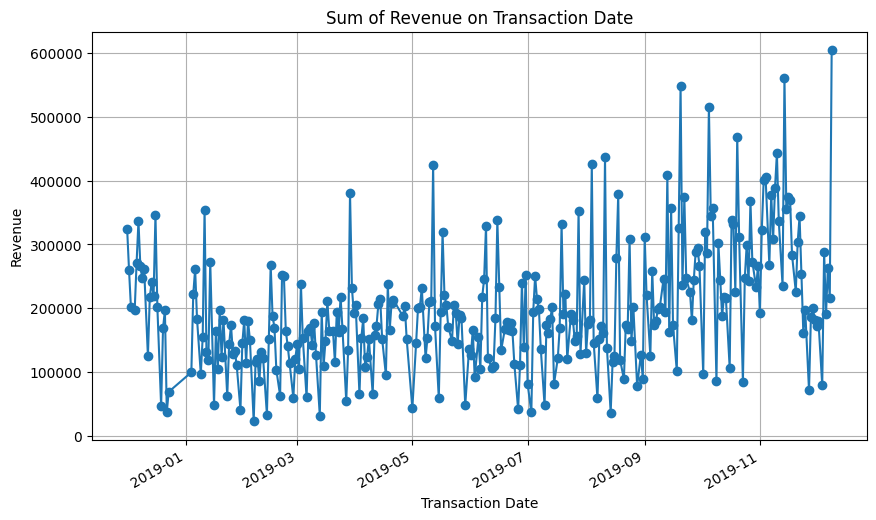

In [ ]:
# Plotting the sum of revenue on each transaction date
df_revenue_by_date = df_pandas.groupby('transaction_date')['Revenue'].sum()

# Plotting the results
plt.figure(figsize=(10, 6))
df_revenue_by_date.plot(kind='line', marker='o')
plt.title("Sum of Revenue on Transaction Date")
plt.ylabel("Revenue")
plt.xlabel("Transaction Date")
plt.grid(True)
plt.show()

### Question 1.3

#### 1.3.1 Analyzing Average Revenue by Workday
To identify which day of the week generates the most sales, we first extract the day of the week from the `transaction_date`. We then calculate the average revenue for each day of the week and plot this information to visualize which day yields the highest average revenue.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


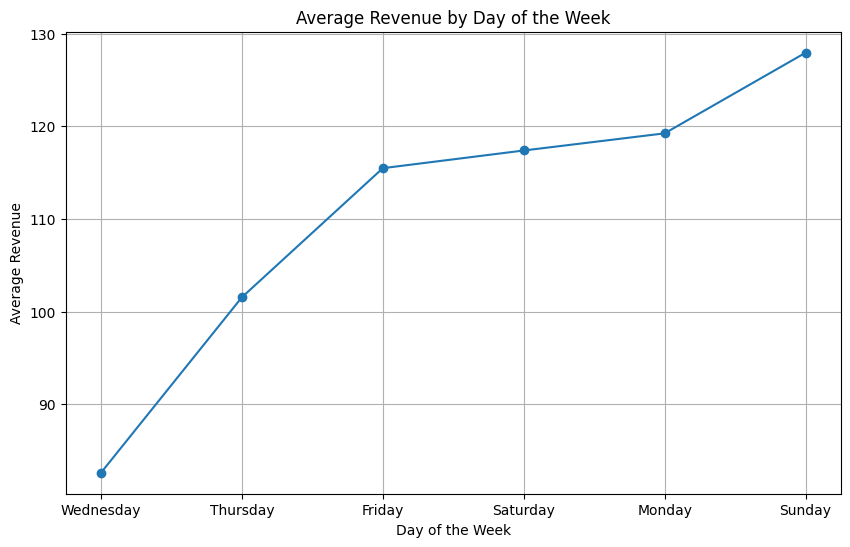

In [ ]:
# Extracting the day of the week from transaction date
df_pandas['day_of_week'] = df_pandas['transaction_date'].dt.day_name()

# Calculating the average revenue per day of the week
avg_revenue_per_day = df_pandas.groupby('day_of_week')['Revenue'].mean().sort_values()

# Plotting the average revenue per day of the week
plt.figure(figsize=(10, 6))
avg_revenue_per_day.plot(kind='line', marker='o')
plt.title("Average Revenue by Day of the Week")
plt.ylabel("Average Revenue")
plt.xlabel("Day of the Week")
plt.grid(True)
plt.show()

#### 1.3.2 Identifying Top Products on the Highest Revenue Workday

From the previous analysis, we determine the day of the week with the highest average revenue. We then filter the data for that specific workday and identify:
*   The product that generates the highest revenue.
*   The product with the highest sales volume (quantity).

In [ ]:
# Finding the day of the week with the highest average revenue
top_workday = avg_revenue_per_day.idxmax()

# Filtering data for that workday
filtered_df = df_pandas[df_pandas['day_of_week'] == top_workday]

# Finding the product with the highest revenue on that workday
highest_revenue_product = filtered_df.groupby('productName_process')['Revenue'].sum().idxmax()

# Finding the product with the highest sales volume on that workday
highest_volume_product = filtered_df.groupby('productName_process')['Quantity'].sum().idxmax()

print(f"Product with highest revenue on {top_workday}: {highest_revenue_product}")
print(f"Product with highest sales volume on {top_workday}: {highest_volume_product}")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Product with highest revenue on Sunday: WorldWarGlidersAsstdDesigns
Product with highest sales volume on Sunday: WorldWarGlidersAsstdDesigns


#### 1.3.3 Plotting Top Products by Revenue and Sales Volume

Finally, we create two plots:
*   The top 5 products by overall revenue.
*   The top 5 products by overall sales volume.

which help in understanding which products are the most successful in terms of revenue and sales volume.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


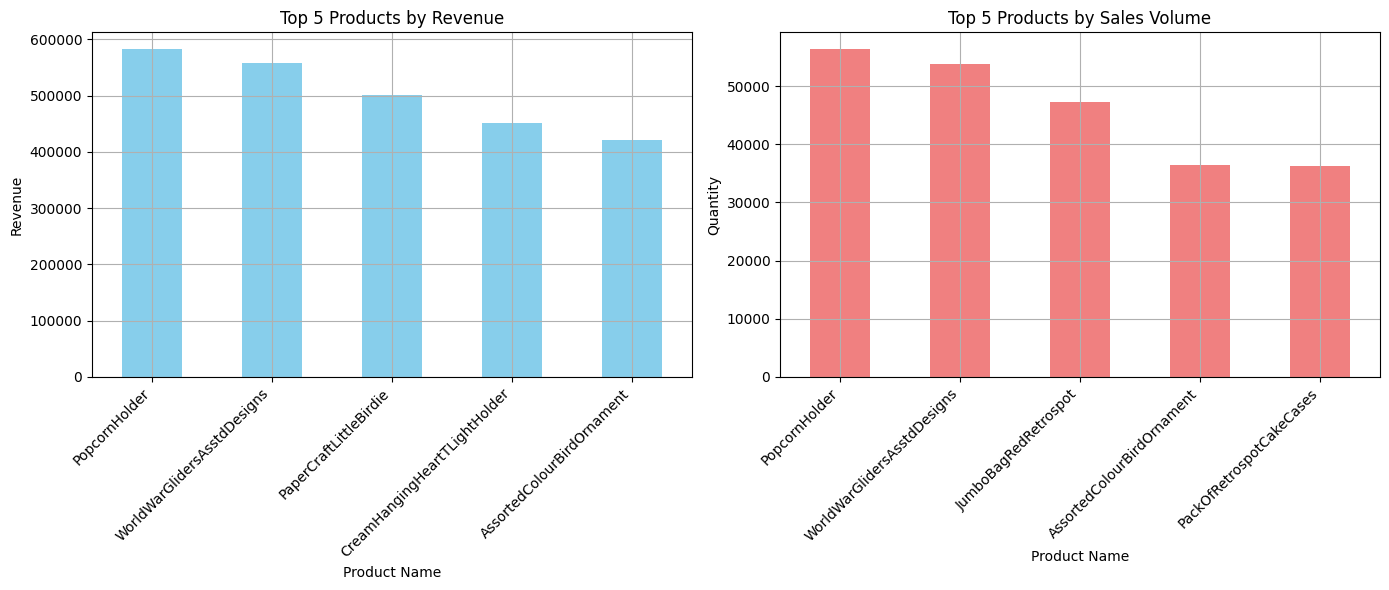

In [ ]:
# Top 5 products by revenue
top_5_revenue_products = df_pandas.groupby('productName_process')['Revenue'].sum().nlargest(5)

# Top 5 products by sales volume
top_5_volume_products = df_pandas.groupby('productName_process')['Quantity'].sum().nlargest(5)

# Plotting the results
plt.figure(figsize=(14, 6))

# Plot for top 5 revenue products
plt.subplot(1, 2, 1)
top_5_revenue_products.plot(kind='bar', color='skyblue')
plt.title("Top 5 Products by Revenue")
plt.xlabel("Product Name")
plt.ylabel("Revenue")
plt.xticks(rotation=45, ha='right')
plt.grid(True)

# Plot for top 5 volume products
plt.subplot(1, 2, 2)
top_5_volume_products.plot(kind='bar', color='lightcoral')
plt.title("Top 5 Products by Sales Volume")
plt.xlabel("Product Name")
plt.ylabel("Quantity")
plt.xticks(rotation=45, ha='right')
plt.grid(True)

plt.tight_layout()
plt.show()


### Question 1.4



#### 1.4.1 Identifying the Country with the Highest Revenue

To determine which country generates the highest revenue, we group the data by `Country` and sum the `Revenue` for each country. The country with the highest total revenue is identified.

In [ ]:
# Aggregating revenue by country
revenue_by_country = df_pandas.groupby('Country')['Revenue'].sum()

# Identifying the country with the highest revenue
top_country = revenue_by_country.idxmax()
top_country_revenue = revenue_by_country.max()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### 1.4.2 Finding the Month with the Highest Revenue in the Top Country

For the country with the highest revenue, we create a filtered `DataFrame` containing only data from that country. We then extract the month from the `transaction_date` and find the month with the highest total revenue in that country.

In [ ]:
# Aggregating revenue by month for the top country
df_pandas['month'] = df_pandas['transaction_date'].dt.to_period('M')
revenue_by_month = df_pandas[df_pandas['Country'] == top_country].groupby('month')['Revenue'].sum()

# Identifying the month with the highest revenue in that country
top_month = revenue_by_month.idxmax()
top_month_revenue = revenue_by_month.max()

print(f"Country with highest revenue: {top_country} (${top_country_revenue})")
print(f"Month with highest revenue in {top_country}: {top_month} (${top_month_revenue})")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Country with highest revenue: United Kingdom ($49994030.17)
Month with highest revenue in United Kingdom: 2019-11 ($6737639.97)


### Question 1.5





#### 1.5.1 Determining Shopping Frequency

To identify the customer who shops most frequently, we first filter out transactions where `Quantity` is less than or equal to 0, as these do not represent shopping activity. We then calculate the distinct count of `TransactionNo` for each customer and find the customer with the highest count.

In [ ]:
# Filtering out transactions where Quantity is less than or equal to 0
filtered_transactions = df_pandas[df_pandas['Quantity'] > 0]
# Finding the customer with the highest distinct count of transactionNo
most_frequent_customer = filtered_transactions.groupby('CustomerNo')['TransactionNo'].nunique().idxmax()
print(f"Customer with the highest distinct count of transactions: {most_frequent_customer}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Customer with the highest distinct count of transactions: 12748


#### 1.5.2 Finding Products Typically Purchased

For the most frequent customer, we filter the transactions specific to that `CustomerNo` and then analyze the products they typically buy based on the `Quantity` of products purchased. We determine the top products by summing the quantities for each product.

In [ ]:
# Filtering the data for this specific customer
customer_df = filtered_transactions[filtered_transactions['CustomerNo'] == most_frequent_customer]
# Finding the products typically bought by this customer based on the sum of the Quantity purchased
top_products = customer_df.groupby('productName_process')['Quantity'].sum().sort_values(ascending=False).head()

print(f"Products typically bought by customer {most_frequent_customer} based on quantity:")
print(top_products)

Products typically bought by customer 12748 based on quantity:
productName_process
VictorianMetalPostcardSpring     595
WorldWarGlidersAsstdDesigns      480
RoseScentCandleJewelledDrawer    408
CartoonPencilSharpeners          405
SmallWhiteRetrospotMugInBox      390
Name: Quantity, dtype: int32


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Question 1.6

#### 1.6.1 Grouping Product Information by Transaction

As part of the basket-level analysis, we start by filtering the dataframe to include only valid purchases where the `Quantity` is greater than 0. After filtering, we group the transactions by `TransactionNo` to aggregate product information at the transaction level. Specifically, we:

*   Group and aggregate the `Product_category` values into a list, which helps in tracking the product categories bought in the same transaction.
*   Group and aggregate the `productName_process` values into a list to capture the specific products purchased during each transaction.

The resulting dataframe `grouped_df` provides a transaction-level view of the product categories and product names purchased together.



In [ ]:
# Filtering the dataframe to include only rows where Quantity > 0
filtered_df = df_pandas[df_pandas['Quantity'] > 0]

# Grouping by transactionNo and aggregate product_category and productName_process into lists
grouped_df = filtered_df.groupby('TransactionNo').agg({
    'Product_category': lambda x: list(x),  # Aggregate product_category into a list
    'productName_process': lambda x: list(x)  # Aggregate productName_process into a list
}).reset_index()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### 1.6.2 Removing Adjacent Duplicates from Product Categories

In this step, we address the issue of adjacent duplicate entries within the `Product_category` lists obtained from the previous step. Specifically, for each transaction, we process the `Product_category` column to remove any duplicates that appear consecutively, ensuring that the sequence of product categories is unique for adjacent elements. For example, a list such as `[product category 1, product category 1, product category 2]` will be processed as `[product category 1, product category 2]`.

To achieve this, we:

*   Define a custom function `remove_adjacent_duplicates`, which iterates through the list of product categories and removes adjacent duplicates.
*   Apply this function to the `Product_category` column, creating a new column `product_category_processed` in the dataframe.
*   Save the processed dataframe as `df_1` and print the top 10 rows for verification.










In [ ]:
# Functioning to remove adjacent duplicates from a list
def remove_adjacent_duplicates(category_list):
    if not category_list:
        return []
    result = [category_list[0]]
    for item in category_list[1:]:
        if item != result[-1]:  # Only adding if it's different from the last element in result
            result.append(item)
    return result

# Applying the function to the product_category column
grouped_df['product_category_processed'] = grouped_df['Product_category'].apply(remove_adjacent_duplicates)

# Creating the final processed dataframe (df_1) and displaying the top 10 rows
df_1 = grouped_df[['TransactionNo', 'product_category_processed', 'productName_process']]
pd.set_option('display.max_colwidth', None)
print(df_1.head(10))


  TransactionNo product_category_processed  \
0        536365                      [0ca]   
1        536366                      [0ca]   
2        536367                      [0ca]   
3        536368                      [0ca]   
4        536369                      [0ca]   
5        536370                      [0ca]   
6        536371                      [0ca]   
7        536372                      [0ca]   
8        536373                      [0ca]   
9        536374                      [0ca]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                productName_process  
0                      

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Question 1.7

#### 1.7.1 Calculate the Product Category List Length

We first create a new column `prod_len` to determine the length of the list in the `product_category_processed` column for each transaction. This helps in understanding how many different product categories are involved in each transaction. After adding the `prod_len` column, we display the first five rows of the dataframe `df_1` to verify the addition.

In [ ]:
# Adding 'prod_len' Column
df_1['prod_len'] = df_1['product_category_processed'].apply(len)
print("First five rows of df_1 with 'prod_len':")
print(df_1.head())

First five rows of df_1 with 'prod_len':
  TransactionNo product_category_processed  \
0        536365                      [0ca]   
1        536366                      [0ca]   
2        536367                      [0ca]   
3        536368                      [0ca]   
4        536369                      [0ca]   

                                                                                                                                                                                                                                                                                               productName_process  \
0                                                                                                         [CreamHangingHeartTLightHolder, WhiteMoroccanMetalLantern, CreamCupidHeartsCoatHanger, KnittedUnionFlagHotWaterBottle, RedWoollyHottieWhiteHeart, SetBabushkaNestingBoxes, GlassStarFrostedTLightHolder]   
1                                                             

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### 1.7.2 Transforming Product Category List into Path Format

In this task, we transform the `product_category_processed` column from a list format into a sequence of transitions representing the customer’s journey, starting from 'start' and ending with 'conversion'. The format of the transformation follows this structure: `'start > productcategory1 > productcategory2 > ... > conversion'`.

To achieve this, we define a function `data_processing` that filters the dataframe based on the length of the product category list (`prod_len`), and then applies a transformation to create the `path` for each transaction.



In [ ]:
# Defining the data_processing function
def data_processing(df, maxlength=3, minlength=1):
    # Filtering dataframe based on prod_len
    filtered_df = df[(df['prod_len'] <= maxlength) & (df['prod_len'] >= minlength)].copy()

    # Functioning to transform list to 'start > ... > conversion' format
    def transform_to_path(category_list):
        if not category_list:
            return 'start > conversion'
        return 'start > ' + ' > '.join(category_list) + ' > conversion'

    # Applying the transformation to the 'product_category_processed' column
    filtered_df['path'] = filtered_df['product_category_processed'].apply(transform_to_path)

    # Returning the new dataframe with 'path' column
    return filtered_df[['TransactionNo', 'product_category_processed', 'prod_len', 'path']]

# Applying the data_processing function to df_1
df_2 = data_processing(df_1, maxlength=5, minlength=2)

# Printing the top 10 rows of the new dataframe df_2
print("Top 10 rows of df_2:")
print(df_2.head(10))

Top 10 rows of df_2:
   TransactionNo product_category_processed  prod_len  \
13        536378            [0ca, 1ca, 0ca]         3   
27        536395            [0ca, 1ca, 0ca]         3   
36        536404  [0ca, 1ca, 0ca, 4ca, 0ca]         5   
40        536408            [0ca, 1ca, 0ca]         3   
42        536412            [0ca, 4ca, 0ca]         3   
43        536415            [0ca, 1ca, 0ca]         3   
52        536464            [0ca, 1ca, 0ca]         3   
72        536532            [0ca, 1ca, 0ca]         3   
82        536542                 [0ca, 4ca]         2   
83        536544  [0ca, 1ca, 0ca, 4ca, 0ca]         5   

                                                path  
13              start > 0ca > 1ca > 0ca > conversion  
27              start > 0ca > 1ca > 0ca > conversion  
36  start > 0ca > 1ca > 0ca > 4ca > 0ca > conversion  
40              start > 0ca > 1ca > 0ca > conversion  
42              start > 0ca > 4ca > 0ca > conversion  
43              start

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Question 1.8

#### 1.8.1 Count the Transactions Ending with Specific Patterns

We define a function `count_end_patterns` that iterates through a list of patterns, checks whether the path column ends with each specified pattern (from the question) followed by > conversion, and counts how many transactions match the pattern.




In [ ]:
# Counting Transactions Ending with Specific Patterns
def count_end_patterns(df, patterns):
    counts = {}
    for pattern in patterns:
        pattern_str = f" > {pattern} > conversion"
        counts[pattern] = df['path'].str.endswith(pattern_str).sum()
    return counts

patterns_end = ['0ca', '1ca', '2ca', '3ca', '4ca']
end_counts = count_end_patterns(df_2, patterns_end)
print("Counts for patterns ending with 'conversion':", end_counts)

Counts for patterns ending with 'conversion': {'0ca': 3056, '1ca': 26, '2ca': 144, '3ca': 68, '4ca': 198}


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### 1.8.2 Counting Specific Patterns in Transactions

We define another function `count_specific_patterns` that takes a dataframe and a list of patterns, and counts how many times each pattern appears in the `path` column (which we created in 1.7.2). It uses the `str.count()` method to find occurrences within each transaction and sums the counts across all transactions.

In [ ]:
# Counting Specific Patterns in Transactions
def count_specific_patterns(df, patterns):
    counts = {}
    for pattern in patterns:
        pattern_str = f" > {pattern}"
        counts[pattern] = df['path'].str.count(pattern_str).sum()
    return counts

patterns_specific = ['0ca > 0ca', '0ca > 1ca', '0ca > 2ca', '0ca > 3ca', '0ca > 4ca', '0ca > conversion']
specific_counts = count_specific_patterns(df_2, patterns_specific)
print("Counts for specific patterns:", specific_counts)

Counts for specific patterns: {'0ca > 0ca': 0, '0ca > 1ca': 1222, '0ca > 2ca': 1137, '0ca > 3ca': 343, '0ca > 4ca': 1198, '0ca > conversion': 3056}


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### 1.8.3 Count the Transactions Containing the Pattern ‘... > 0ca > ...’



*   Define the `pattern_including_0ca` which represent ` > 0ca >
*   Count the occurences of the pattern by using `str.count()`method. It counts how many times the pattern appears within the `path` column for each transaction. The counts are then summed across all transactions to get the total number of occurrences.





In [ ]:
# Counting Transactions Containing Pattern '... > 0ca > ...'
pattern_including_0ca = ' > 0ca > '
count_including_0ca = df_2['path'].str.count(pattern_including_0ca).sum()
print("Count for '... > 0ca > ...':", count_including_0ca)

Count for '... > 0ca > ...': 6956


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### 1.8.4 Calculate the Final Result by Using the Results from 1.8.2 and 1.8.3



*   Sum the counts from 1.8.2
*   Divide the result from 1.8.3 by the sum of counts from 1.8.2. If the sum of the counts from 1.8.2 is zero, set the result as 0 to avoid 0 division by zero.



In [ ]:
# Performing the Calculation
total_specific_counts = sum(specific_counts.values())
result = count_including_0ca / total_specific_counts if total_specific_counts != 0 else 0
print("Result for 1.8.4:", result)

Result for 1.8.4: 1.0


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Question 1.9

#### 1.9.1 Build a Transaction-Level Product DataFrame

We construct a transaction-level product dataframe, where each row represents a `TransactionNo`, and each product becomes a column. The value in each column corresponds to the `Quantity` of the product purchased in that transaction.

The dataframe has:

*   Filter out transactions with negative `Quantity`
*   Select the top 100 products by total `Quantity`



In [ ]:
# Filter out transactions with negative Quantity values
filtered_df = df_pandas[df_pandas['Quantity'] > 0]

# Calculate the total quantity sold for each product and keep the top 100 products
top_100_products = filtered_df.groupby('productName_process')['Quantity'].sum().nlargest(100).index

# Filter the dataframe to include only the top 100 products
filtered_df_top_100 = filtered_df[filtered_df['productName_process'].isin(top_100_products)]

# Pivot the dataframe to create the transaction-level product dataframe
# Each row represents TransactionNo, and each product becomes a column with the Quantity as the value
transaction_level_df = filtered_df_top_100.pivot_table(
    index='TransactionNo',
    columns='productName_process',
    values='Quantity',
    aggfunc='sum',
    fill_value=0
)

# Display the transaction-level product dataframe
print(transaction_level_df.head())


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


productName_process  AgedGlassSilverTLightHolder  AntiqueSilverTLightGlass  \
TransactionNo                                                                
536365                                         0                         0   
536367                                         0                         0   
536370                                         0                         0   
536371                                         0                         0   
536373                                         0                         0   

productName_process  AssortedColourBirdOrnament  AssortedColoursSilkFan  \
TransactionNo                                                             
536365                                        0                       0   
536367                                       32                       0   
536370                                        0                       0   
536371                                        0                       0   
536

#### 1.9.2 Run the Apriori Algorithm to idenitfy the items with minimum support of 1.5%

We use the `mlxtend.frequent_patterns` module to idenitfy the items by followings:



*   Filter out transactions (baskets) with fewer than 4 items.
*   Use One-Hot Encoding to convert the `DataFrame` from `quantities` to `boolean` values. This is because the apriori algorith requires a boolean DataFrame.
*   Apply apriori with a minimum support of 1.5% to identify the items.
*   List item







In [ ]:
# Filter the transactions with 4 or more items
# Create a new column that counts the number of non-zero quantities in each transaction (i.e., the number of products in each basket)
transaction_level_df['num_items'] = (transaction_level_df > 0).sum(axis=1)

# Filter to keep only transactions with 4 or more items
filtered_transactions = transaction_level_df[transaction_level_df['num_items'] >= 4].drop(columns=['num_items'])

# Convert the DataFrame to boolean values (1 if product is present, 0 if not)
transaction_level_df_bool = (filtered_transactions > 0)

# Apply the Apriori algorithm with a minimum support of 1.5%
frequent_itemsets = apriori(transaction_level_df_bool, min_support=0.015, use_colnames=True)

# Display the frequent itemsets
print(frequent_itemsets.head())


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


    support                       itemsets
0  0.031276  (AgedGlassSilverTLightHolder)
1  0.085835     (AntiqueSilverTLightGlass)
2  0.126928   (AssortedColourBirdOrnament)
3  0.054698       (AssortedColoursSilkFan)
4  0.057083            (BaggSwirlyMarbles)


Interpretation:

The apriori algotihm has identified the five frequently purchased items are 'AgedGlassSilverTLightHolder', 'AntiqueSilverTLightGlass', 'AssortedColourBirdOrnament', 'AssortedColoursSilkFan', and 'BaggSwirlyMarbles' with their corresponding support values indicating how often they appear in transactions. Among these, "AssortedColourBirdOrnament" is the most frequently bought item, appearing in approximately 12.26% of all transactions.


#### 1.9.3 Finding Items with Support ≥ 1.0% and Lift > 10

In [ ]:
# Apply the Apriori algorithm with a minimum support of 1.0%
frequent_itemsets = apriori(transaction_level_df_bool, min_support=0.01, use_colnames=True)

# Display the frequent itemsets with support ≥ 1.0%
print("Frequent itemsets with support ≥ 1.0%:")
print(frequent_itemsets.head())

# Generate the association rules
from mlxtend.frequent_patterns import association_rules

# Generate association rules with the minimum support found earlier
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=10)

# Filter rules with lift > 10
filtered_rules = rules[rules['lift'] > 10]

# Display the filtered rules with lift > 10
print("Association rules with lift > 10:")
print(filtered_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head())


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Frequent itemsets with support ≥ 1.0%:
    support                       itemsets
0  0.031276  (AgedGlassSilverTLightHolder)
1  0.085835     (AntiqueSilverTLightGlass)
2  0.126928   (AssortedColourBirdOrnament)
3  0.054698       (AssortedColoursSilkFan)
4  0.010799     (AssortedFlowerColourLeis)
Association rules with lift > 10:
                                                    antecedents  \
0                            (WoodenHeartChristmasScandinavian)   
1                             (WoodenStarChristmasScandinavian)   
2  (WoodenHeartChristmasScandinavian, AntiqueSilverTLightGlass)   
3   (AntiqueSilverTLightGlass, WoodenStarChristmasScandinavian)   
4                            (WoodenHeartChristmasScandinavian)   

                                                   consequents   support  \
0                            (WoodenStarChristmasScandinavian)  0.042637   
1                           (WoodenHeartChristmasScandinavian)  0.042637   
2                            (WoodenSt

Interpretation:




*   "WoodenHeartChristmasScandinavian" frequently bought with "WoodenStarChristmasScandinavian," both with a lift of 15.66 and support of 3.93%
*   "PaperChainKitVintageChristmas" and "RedRetrospotCharlotteBag," which often lead to the purchase of "CharlotteBagPinkPolkadot," with a lift of 10.12.







#### 1.9.4 Explore Patterns by Using Different Support, Confidence, and Lift Thresholds

Explore the patterns by following different setting:

| **Example** | **Support Threshold** | **Confidence Threshold** | **Lift Threshold** |
|-------------|-----------------------|--------------------------|--------------------|
| Example 1   | 2%                    | 50%                      | 5                  |
| Example 2   | 1.5%                  | 60%                      | 7                  |
| Example 3   | 1%                    | 70%                      | 8                  |



In [ ]:
# Applying Apriori with different support thresholds

# Example 1: Minimum support = 0.02 (2%)
frequent_itemsets_1 = apriori(transaction_level_df_bool, min_support=0.02, use_colnames=True)
rules_1 = association_rules(frequent_itemsets_1, metric="confidence", min_threshold=0.5)  # Confidence ≥ 50%
rules_1 = rules_1[rules_1['lift'] > 5]  # Lift > 5

# Example 2: Minimum support = 0.015 (1.5%)
frequent_itemsets_2 = apriori(transaction_level_df_bool, min_support=0.015, use_colnames=True)
rules_2 = association_rules(frequent_itemsets_2, metric="confidence", min_threshold=0.6)  # Confidence ≥ 60%
rules_2 = rules_2[rules_2['lift'] > 7]  # Lift > 7

# Example 3: Minimum support = 0.01 (1%), confidence = 70%, and lift > 8
frequent_itemsets_3 = apriori(transaction_level_df_bool, min_support=0.01, use_colnames=True)
rules_3 = association_rules(frequent_itemsets_3, metric="confidence", min_threshold=0.7)  # Confidence ≥ 70%
rules_3 = rules_3[rules_3['lift'] > 8]  # Lift > 8

# Displaying results for all three examples
print("Example 1: Rules with support ≥ 2%, confidence ≥ 50%, lift > 5")
print(rules_1[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head())

print("\nExample 2: Rules with support ≥ 1.5%, confidence ≥ 60%, lift > 7")
print(rules_2[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head())

print("\nExample 3: Rules with support ≥ 1%, confidence ≥ 70%, lift > 8")
print(rules_3[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head())



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Example 1: Rules with support ≥ 2%, confidence ≥ 50%, lift > 5
                  antecedents                 consequents   support  \
1  (CharlotteBagPinkPolkadot)    (CharlotteBagSukiDesign)  0.056381   
2  (RedRetrospotCharlotteBag)  (CharlotteBagPinkPolkadot)  0.072230   
3  (CharlotteBagPinkPolkadot)  (RedRetrospotCharlotteBag)  0.072230   
4  (CharlotteBagPinkPolkadot)    (StrawberryCharlotteBag)  0.052314   
5    (StrawberryCharlotteBag)  (CharlotteBagPinkPolkadot)  0.052314   

   confidence      lift  
1    0.574286  5.067645  
2    0.534787  5.447189  
3    0.735714  5.447189  
4    0.532857  5.538297  
5    0.543732  5.538297  

Example 2: Rules with support ≥ 1.5%, confidence ≥ 60%, lift > 7
                                             antecedents  \
18                    (WoodenHeartChristmasScandinavian)   
19                     (WoodenStarChristmasScandinavian)   
23  (CakeCasesVintageChristmas, PaperChainKitSChristmas)   
26                (CharlotteBagSukiDesign, Chill

Intepretation:



*   In all three examples, the rules identified show strong relationships with high confidence and lift values, especially between WoodenHeartChristmasScandinavian and WoodenStarChristmasScandinavian with a lift of 15.66.
*   In Example 1, CharlotteBagPinkPolkadot is frequently associated with other Charlotte bags, showing moderate association strength.
*   Example 2 and Example 3 highlight stronger relationships, especially between DollyGirlLunchBox and SpaceboyLunchBox, and various Christmas-themed items with high lift values.






### Question 1.10

#### 1.10.1 Build a Customer-Product DataFrame

We first filter out the dataframe that the have negative `Quantity` and only select top 100 products.

Then we use the `pivot_table` function to create a matrix where each row represents a customer (`CustomerNo`), and each column represents a product. The values in the table are the aggregated `Quantity` of that product purchased by each customer.

In [ ]:
# Filter out transactions with negative quantity values
filtered_df = df_pandas[df_pandas['Quantity'] > 0]

# Calculate the total quantity sold for each product and keep the top 100 products
top_100_products = filtered_df.groupby('productName_process')['Quantity'].sum().nlargest(100).index

# Filter the dataframe to include only the top 100 products
filtered_top_100_df = filtered_df[filtered_df['productName_process'].isin(top_100_products)]

# Create the customer-product dataframe
# Pivot the dataframe such that each row is a customer (CustomerNo) and each product becomes a column
# The values in the columns represent the aggregated Quantity of that product for each customer
CustomerProduct_df = filtered_top_100_df.pivot_table(
    index='CustomerNo',
    columns='productName_process',
    values='Quantity',
    aggfunc='sum',
    fill_value=0
)

# Display the resulting customer-product dataframe
print("Customer-Product DataFrame (Top 5 rows):")
print(CustomerProduct_df.head())



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Customer-Product DataFrame (Top 5 rows):
productName_process  AgedGlassSilverTLightHolder  AntiqueSilverTLightGlass  \
CustomerNo                                                                   
12004                                          0                         0   
12008                                          1                        40   
12025                                          0                         0   
12026                                          0                         0   
12031                                          0                         0   

productName_process  AssortedColourBirdOrnament  AssortedColoursSilkFan  \
CustomerNo                                                                
12004                                         0                       0   
12008                                         0                       0   
12025                                         0                       0   
12026                                

#### 1.10.2 Calculate the Pairwise Euclidean Distance on Customer Level

We based on the customer-product dataframe from question 1.10.1 to calculate the Pairwise Euclidean distance on the customer level. First, we use the product `Quantity` information for each customer to calculate the `Euclidean distance` between all customers.

In [ ]:
# Calculate the pairwise Euclidean distances between customers
# The 'pdist' function computes the pairwise distances between rows of the dataframe
# The 'squareform' function converts the condensed distance matrix into a square matrix
euclidean_distances = pdist(CustomerProduct_df, metric='euclidean')
euclidean_distance_matrix = squareform(euclidean_distances)

# Convert the distance matrix to a DataFrame for better readability
distance_matrix_df = pd.DataFrame(
    euclidean_distance_matrix,
    index=CustomerProduct_df.index,  # Set the CustomerNo as the row index
    columns=CustomerProduct_df.index  # Set the CustomerNo as the column headers
)

# Display the pairwise Euclidean distance matrix (first 5 rows and columns for brevity)
print("Pairwise Euclidean Distance Matrix (Top 5 rows and columns):")
print(distance_matrix_df.iloc[:5, :5])


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Pairwise Euclidean Distance Matrix (Top 5 rows and columns):
CustomerNo      12004      12008      12025      12026      12031
CustomerNo                                                       
12004        0.000000  42.130749  13.152946  10.049876   9.949874
12008       42.130749   0.000000  43.474130  41.737274  42.308392
12025       13.152946  43.474130   0.000000  15.231546   9.899495
12026       10.049876  41.737274  15.231546   0.000000   9.695360
12031        9.949874  42.308392   9.899495   9.695360   0.000000


In [ ]:
# Check if CustomerNo 13069 is present in the distance matrix
if '13069' in distance_matrix_df.index:
    print("CustomerNo 13069 is present in the distance matrix.")
else:
    print("CustomerNo 13069 is not present in the distance matrix.")


CustomerNo 13069 is present in the distance matrix.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### 1.10.3 Identify the Top Most Similar Customers to 13069 and 17490

In [ ]:
# Define a function to find the top 3 most similar customers based on Euclidean distance
def find_top_3_similar(customerno, distance_matrix):
    # Get the distances for the specified customer
    customer_distances = distance_matrix.loc[customerno]

    # Sort the distances and exclude the customer itself (distance = 0)
    similar_customers = customer_distances.sort_values()[1:4]  # Exclude self (first entry) and get top 3

    return similar_customers

# Find the top 3 most similar customers for CustomerNo == 13069
top_3_customers_13069 = find_top_3_similar('13069', distance_matrix_df)
print(f"Top 3 most similar customers to CustomerNo 13069:\n{top_3_customers_13069}")

# Find the top 3 most similar customers for CustomerNo == 17490
top_3_customers_17490 = find_top_3_similar('17490', distance_matrix_df)
print(f"Top 3 most similar customers to CustomerNo 17490:\n{top_3_customers_17490}")

Top 3 most similar customers to CustomerNo 13069:
CustomerNo
15118     598.369451
17523    1449.092820
18179    1734.755891
Name: 13069, dtype: float64
Top 3 most similar customers to CustomerNo 17490:
CustomerNo
12519    26.00000
12582    26.00000
12652    26.70206
Name: 17490, dtype: float64


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### 1.10.4 Recommendations for CustomerNo 13069

Since there are some products that CustomerNo 13069 has never shopped before. We suggest using the below two recommendation system which could help to recommend most relevant products to the him/her:

Option 1: Collaborative Filtering
This recommendation system assume customers with similar past purchasing behaviors will likely have similar purchasing preferences. So, based on the 1.10.3 result, we can see the top 3 most simialr customers to CustomerNo 13069 are 15118, 17523 and 18179. We can first retrieve the list of products purchased by these similar customers. Then compare the similarity of purchased products between these similar customers and CustomerNo 13069. If we find there are products which purchased by these customers but CustomerNo 13069 still hasn't bought yet. We can recommend these products to CustomerNo 13069.

Option 2: Content-Based Filtering
This recommendation on the other hand focus on individual customer's taste and preference based on the attributes of the products they have bought. We can first identify the list of product that CustomerNo 13069 has already purchased. Then identify other products in the catalog that are similar but still not purchased by him/her yet. Lastly, we can recommend these products to him/her.